# Sobol Sensitivity Indices

Saleh Rezaeiravesh, salehr@kth.se <br/>
SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Stockholm, Sweden


In [1]:
import os
import sys
import numpy as np
import math as mt
import matplotlib.pyplot as plt
sys.path.append(os.getenv("UQit"))
from sobol import sobol
import analyticTestFuncs
import pce
import reshaper
import sampling

### Example 1: Sobol indices for 2 uniform parameters

Consider the following analytical function, 
$$
\begin{equation}
f(\mathbf{q}) = q_1^2+q_1 q_2
\label{eq:1dModel}\tag{3}
\end{equation}
$$

where $\mathbf{q}=\{q_1,q_2\}$, and both parameters are random with uniform distributions, i.e., $q_1\sim \mathcal{U}[\mathbb{Q}_1]$ and $q_2\sim \mathcal{U}[\mathbb{Q}_2]$. 
The aim is to compute the main Sobol indices using `UQit` and validate them with the analytical values..

The above model function (simulator) is implemented in `analyticTestFuncs.fEx2D` with keyword `type3`. 

**Step 1:** Set the number of samples for $q_1$ and $q_2$ and their associated admissible spaces $\mathbb{Q}_1$ and $\mathbb{Q}_2$

In [2]:
n=[100, 90]       #number of samples for q1 and q2
qBound=[[-3,1],   #admissible space of q1 and q2
        [-1,2]]

**Step 2:** Generate samples for parameters $q_1$ and $q_2$. We choose to have samples to be uniformly spaced over the parameter spaces. 

In [3]:
p=len(n)
q=[]
pdf=[]
for i in range(p):
    q.append(np.linspace(qBound[i][0],qBound[i][1],n[i]))
    pdf.append(np.ones(n[i])/(qBound[i][1]-qBound[i][0]))

**Step 3:** Run the simulator (3) at the parameter samples to generate training model outputs. We assume that a 2D sample parameter is obtained by tensor product of the samples for $q_1$ and $q_2$. 

In [4]:
fEx_=analyticTestFuncs.fEx2D(q[0],q[1],'type3','tensorProd')
fEx=np.reshape(fEx_.val,n,'F')

**Step 4:** Compute first- and second-order main and also total Sobol sensitivity indices:

In [5]:
sobol_=sobol(q,fEx,pdf)
Si=sobol_.Si
STi=sobol_.STi
Sij=sobol_.Sij

**Step 5:** Validate the computed Sobol indices through comparison with the analytical values. To this end, we have derived expressions to compute the exact Sobol indices for the above model function. Note that, in general since the exact form of the model function (simulator) is not known, exact Sobol indices can not be evaluated. 

In [6]:
fEx_.sobol(qBound)
Si_ex=fEx_.Si
STi_ex=fEx_.STi
Sij_ex=fEx_.Sij

**Results:**

In [7]:
print('Main indices by UQit:\n\t S1=%g, S2=%g, S12=%g' %(Si[0],Si[1],Sij[0]))
print('Analytical main Indices:\n\t S1=%g, S2=%g, S12=%g' %(Si_ex[0],Si_ex[1],Sij_ex[0]))

Main indices by UQit:
	 S1=0.716474, S2=0.121511, S12=0.162015
Analytical main Indices:
	 S1=0.716472, S2=0.121512, S12=0.162016


**Extra:** In the above example, all the required samples to compute the Sobol indices were drawn directly from the simulator. This can be the case when running the simulator is computationally inexpensive. But in practice, we need to deal with the cases where the computational cost of running the simulator limits the number of training samples. 
In such situations, we need to construct a surrogate based on a limited number of training data and then use the surrogate to compute the Sobol indices. 

Following this procedure, we repeat the previous example. 

**Step 1:** Draw a few samples to construct the PCE surrogate. We choose to have the parameter samples to be Gauss-Legendre points. The simulator is run at these parameter samples. 

In [8]:
nQpce=[5,6]    #number of samples from q1, q2 to construct surrogate
xi=[]
qpce=[]
for i in range(p):
    samps=sampling.trainSample(sampleType='GQ',GQdistType='Unif',qInfo=qBound[i],nSamp=nQpce[i])
    xi.append(samps.xi)
    qpce.append(samps.q)
fVal_pceCnstrct=analyticTestFuncs.fEx2D(qpce[0],qpce[1],'type3','tensorProd').val

**Step 2:** Construct the PCE surrogate

In [9]:
xiGrid=reshaper.vecs2grid(xi)
pceDict={'p':2,'sampleType':'GQ','truncMethod':'TP','pceSolveMethod':'Projection',
             'distType':['Unif']*p}
pce_=pce.pce(fVal=fVal_pceCnstrct,nQList=nQpce,xi=xiGrid,pceDict=pceDict)

... A gPCE for a 2-D parameter space is constructed.
...... Samples in each direction are Gauss Quadrature nodes (User should check this!).
...... PCE truncation method: TP
...... Method of computing PCE coefficients: Projection
...... Number of terms in PCE, K=  30
...... Number of Data point, n=  30


**Step 3:** Run the surrogate at test samples which are used to compute the Sobol indices. The test samples are taken from $\mathbb{Q}$. 

In [10]:
qpceTest=[]
xiTest=[]
for i in range(p):
    testSamps=sampling.testSample('unifSpaced',GQdistType='Unif',qBound=qBound[i],nSamp=n[i])
    xiTest.append(testSamps.xi)
    qpceTest.append(testSamps.q)
fPCETest_=pce.pceEval(coefs=pce_.coefs,kSet=pce_.kSet,xi=xiTest,distType=['Unif']*2)
fPCETest=fPCETest_.pceVal

**Step 4:** Compute the Sobol indices using the surrogate values. 

In [11]:
sobolPCE_=sobol(qpceTest,fPCETest,pdf)
Si_pce=sobolPCE_.Si
Sij_pce=sobolPCE_.Sij

We can validate the computed indices by comparing them to the values resulted from the previous example (where actual simulator is used). 

In [12]:
print('Indices by the surrogate:\n\t S1=%g, S2=%g, S12=%g' %(Si_pce[0],Si_pce[1],Sij_pce[0]))

Indices by the surrogate:
	 S1=0.716474, S2=0.121511, S12=0.162015


### Example 2: Sobol indices for 2 parameters with Gaussian distributions

Let's do Example 15.7 in [Smith](https://rsmith.math.ncsu.edu/UQ_TIA/).

$$
f(\mathbf{q})=c_1 q_1 +c_2 q_2
$$

where $c_1$ and $c_2$ are constant parameters, and $q_i\sim\mathcal{N}(0,\sigma_i^2)$ for $i=1,2$. 
For different values of $c_1,\,c_2,\,\sigma_1$ and $\sigma_2$, we can compare the Sobol indices computed by `UQit` and associted exact values. 

Settings:

In [13]:
n=[101, 100]        #number of samples for q1 and q2
qBound=[[-20,20],   #admissible range of parameters
        [-20,20]]
sig=[1.,3.]
c=[2,1]

Generate uniformly-spaced values for the parameters; construct and plot the PDFs (probability density functions).

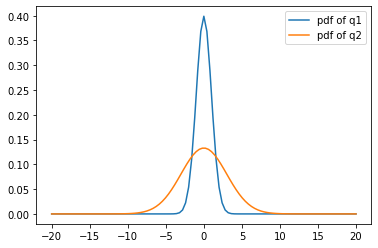

In [14]:
q=[]
pdf=[]
for i in range(p):
    q.append(np.linspace(qBound[i][0],qBound[i][1],n[i]))
    pdf_=np.exp(-q[i]**2/(2*sig[i]**2))/(sig[i]*mt.sqrt(2*mt.pi))
    pdf.append(pdf_)
    plt.plot(q[i],pdf[i],label='pdf of q'+str(i+1))
plt.legend(loc='best')
plt.show()

Compute the function values at the samples

In [15]:
fEx=np.zeros(n)
for j in range(n[1]):
    for i in range(n[0]):
        fEx[i,j]=c[0]*q[0][i]+c[1]*q[1][j]

Compute the Sobol indices

In [16]:
sobol_=sobol(q,fEx,pdf=pdf)
Si=sobol_.Si
STi=sobol_.STi
Sij=sobol_.Sij

Validate the computed indices against corresponding exact values

In [17]:
Si_ex=[(c[0]*sig[0])**2./(c[0]**2*sig[0]**2+c[1]**2*sig[1]**2),
           (c[1]*sig[1])**2./(c[0]**2*sig[0]**2+c[1]**2*sig[1]**2)]
Sij_ex=[0]
print(' > Main Indices by UQit:\n\t S1=%g, S2=%g, S12=%g' %(Si[0],Si[1],Sij[0]))
print(' > Main Analytical Reference:\n\t S1=%g, S2=%g, S12=%g' %(Si_ex[0],Si_ex[1],Sij_ex[0]))

 > Main Indices by UQit:
	 S1=0.307692, S2=0.692308, S12=1.93492e-22
 > Main Analytical Reference:
	 S1=0.307692, S2=0.692308, S12=0


### Example 3: Sobol indices for 3 uniform parameters

Consider the following analytical function, 
$$
\begin{equation}
f(\mathbf{q}) = \sin(q_1)+a\sin^2(q_2)+b\,q_3^4\sin(q_1) \,,
\label{eq:ishigami}\tag{4}
\end{equation}
$$

which is called [Ishigami](https://inis.iaea.org/search/search.aspx?orig_q=RN:21024954) function and widely used  to validate different methods in UQ. 

Here, $a$ and $b$ are two fixed parameters and the uncertain parameters $\mathbf{q}=\{q_1,q_2,q_3\}$ have uniform distributions over the same range: $q_i\sim \mathcal{U}[-\pi,\pi]\,,\quad i=1,2,3$.
The aim is to compute the main Sobol indices using `UQit` and validate them with the analytical values.

The given model function (simulator) is implemented in `analyticTestFuncs.fEx3D` with keyword `Ishigami`. 

Set the number of samples for $q_1$, $q_2$ and $q_3$ and their associated admissible spaces $\mathbb{Q}_1$, $\mathbb{Q}_2$ and $\mathbb{Q}_3$. Also set the model's fixed parameters $a$ and $b$.

In [18]:
n=[100, 70, 80]        #number of samples for q1, q2, q3
qBound=[[-mt.pi,mt.pi],      #admissible space of the parameters
        [-mt.pi,mt.pi],
        [-mt.pi,mt.pi]]
a=7   
b=0.1

Generate uniformly-spaced samples for parameters $q_1$ and $q_2$. Also define the PDFs.

In [19]:
q=[]
pdf=[]
for i in range(len(n)):
    q.append(np.linspace(qBound[i][0],qBound[i][1],n[i]))
    pdf.append(np.ones(n[i])/(qBound[i][1]-qBound[i][0]))

**Step 4:** Run the simulator (4) at the parameter samples to generate training model outputs. We assume that a 3D sample parameter is obtained by tensor-product of the samples for $q_1$, $q_2$ and $q_3$. 

In [20]:
fEx_=analyticTestFuncs.fEx3D(q[0],q[1],q[2],'Ishigami','tensorProd',{'a':a,'b':b})
fEx=np.reshape(fEx_.val,n,'F')

Compute first- and second-order main Sobol sensitivity indices using `UQit`

In [21]:
sobol_=sobol(q,fEx,pdf)
Si=sobol_.Si
Sij=sobol_.Sij
SijName=sobol_.SijName
STi=sobol_.STi

Validate the computed Sobol indices through comparison with the analytical values.  

In [22]:
fEx_.sobol(qBound)
Si_ex=fEx_.Si
STi_ex=fEx_.STi
Sij_ex=fEx_.Sij

**Results:**

In [23]:
#UQit 
print(' > Main Indices by UQit : S1=%g, S2=%g, S3=%g' %(Si[0],Si[1],Si[2]))
print(' >                        S12=%g, S13=%g, S23=%g' %(Sij[0],Sij[1],Sij[2]))
print(' > Total Indices        : ST1=%g, ST2=%g, ST3=%g' %(STi[0],STi[1],STi[2]))
#Reference
print(' > Main Analytical Reference: S1=%g, S2=%g, S3=%g' %(Si_ex[0],Si_ex[1],Si_ex[2]))
print(' >                           S12=%g, S13=%g, S23=%g' %(Sij_ex[0],Sij_ex[1],Sij_ex[2]))
print(' > Total Indices            : ST1=%g, ST2=%g, ST3=%g' %(STi_ex[0],STi_ex[1],STi_ex[2]))

 > Main Indices by UQit : S1=0.313905, S2=0.442312, S3=5.64351e-32
 >                        S12=9.90498e-32, S13=0.243783, S23=8.41268e-32
 > Total Indices        : ST1=0.557688, ST2=0.442312, ST3=0.243783
 > Main Analytical Reference: S1=0.313905, S2=0.442411, S3=0
 >                           S12=0, S13=0.243684, S23=0
 > Total Indices            : ST1=0.557589, ST2=0.442411, ST3=0.243684


### Example 4: Sobol indices for 4 parameters with Gaussian distributions

Let's do Example 15.8 in [Smith](https://rsmith.math.ncsu.edu/UQ_TIA/).

$$
f(\mathbf{q})=q_1 q_3 +q_2 q_4
$$

where $q_i\sim\mathcal{N}(0,\sigma_i^2)$ for $i=1,2,3,4$. 
For different values of $\sigma_i$, we can compare the Sobol indices computed by `UQit` with associted exact values. 

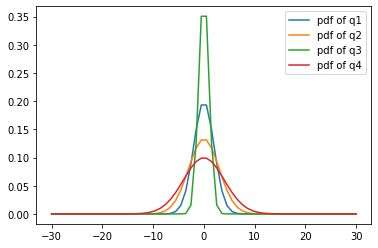

> Main Indices Si by UQit: [5.69332163e-35 4.46886262e-34 3.05804326e-35 1.63131702e-33]
  Sij [1.24593888e-33 2.70270376e-02 1.20563049e-33 1.10254866e-33
 9.72972962e-01 9.90293824e-34]
> Reference Analytical Si: [0, 0, 0, 0]
  Sij [0, 0.02702702702702703, 0, 0, 0.972972972972973, 0]


In [24]:
#Settings
n=[60,60,60,60]       #number of samples for q1 and q2, Method1
qBound=[[-30,30]]*4   #admissible range of parameters
sig=[2.,3.,1,4]    #sdev of q's
#(1) Samples from parameters space + the PDFs
p=len(n)
q=[]
pdf=[]
for i in range(p):
    q.append(np.linspace(qBound[i][0],qBound[i][1],n[i]))
    pdf_=np.exp(-q[i]**2/(2*sig[i]**2))/(sig[i]*mt.sqrt(2*mt.pi))
    pdf.append(pdf_)
#plot PDfs
for i in range(p):
   plt.plot(q[i],pdf[i],label='pdf of q'+str(i+1))
plt.legend(loc='best')
plt.show()
#(2) Compute function value at the parameter samples
fEx=np.zeros(n)
for i3 in range(n[3]):
    for i2 in range(n[2]):
        for i1 in range(n[1]):
            for i0 in range(n[0]):
                fEx[i0,i1,i2,i3]=q[0][i0]*q[2][i2]+q[1][i1]*q[3][i3]
#(3) Compute Sobol indices direct numerical integration
sobol_=sobol(q,fEx,pdf=pdf)
Si=sobol_.Si
STi=sobol_.STi
Sij=sobol_.Sij
#(5) Exact Sobol indices (analytical expressions)
Si_ex=[0]*p
Sij_ex=[0,(sig[0]*sig[2])**2./((sig[0]*sig[2])**2.+(sig[1]*sig[3])**2.),0,0,
        (sig[1]*sig[3])**2./((sig[1]*sig[3])**2.+(sig[0]*sig[2])**2.),0]
#(6) Results
print('> Main Indices Si by UQit:',Si)
print('  Sij',Sij)
print('> Reference Analytical Si:',Si_ex)
print('  Sij',Sij_ex)

### Example 5: Sobol indices for arbitrary number of parameters with uniform distributions

Here we consider the test case which is considered in the original article by [Sobol](https://www.sciencedirect.com/science/article/abs/pii/S0378475400002706) as well as in Example 15.17 in [Smith](https://rsmith.math.ncsu.edu/UQ_TIA/):

$$
f(\mathbf{q})=\prod_{i=1}^p g_i(q_i)\,,\quad g_i(q_i)=\frac{|4q_i-2|+a_i}{1+a_i}\,, a_i\geq 0
$$

Assume $q_i\sim\mathcal{U}[0,1]$ for $i=1,2,\cdots,p$ for any $p>1$.

In [25]:
#---SETTINGS ---------------
a=[0.5,0.2,1.2,0.4,0.25]   #coefficients in the model => p is determined from the length of this list
nSamp=[20,20,21,22,25]   
#---------------------------
p=len(a)
qBound=[[0,1]]*p
#Generate samples, compute PDFs and evaluate model response at the samples
q=[]
pdf=[]
for i in range(p):
    q_=np.linspace(qBound[i][0],qBound[i][1],nSamp[i])
    q.append(q_)
    pdf.append(np.ones(nSamp[i])/(qBound[i][1]-qBound[i][0]))
    fEx_=(abs(4*q_-2)+a[i])/(1+a[i])
    if i==0:
       fEx=fEx_
    else:
       fEx=np.tensordot(fEx,fEx_,0)
#Computed Sobol indices
sobol_=sobol(q,fEx,pdf)
#Exact reference Sobol indices (Smith, p.336)
Di=[]
Dsum=1
for i in range(p):
    Di.append(1/(3*(1+a[i])**2.))
    Dsum*=(1+Di[i])
Dsum=-1+Dsum
Di=np.asarray(Di)
Si=Di/Dsum
Dij=[]
for i in range(p):
    for j in range(p):
        if i!=j and i<j:
           Dij.append(Di[i]*Di[j])
Dij=np.asarray(Dij)
Sij=Dij/Dsum
print('Computed Indices by UQit:')
print(' Si:',sobol_.Si)
print(' Sij-Name:',sobol_.SijName)
print(' Sij:',sobol_.Sij)
print(' STi:',sobol_.STi)
print('Exact Sobol Indices:')
print(' Si:',Si)
print(' Sij:',Sij)

Computed Indices by UQit:
 Si: [0.13445718 0.21002473 0.06285799 0.15448376 0.1947089 ]
 Sij-Name: ['S12', 'S13', 'S14', 'S15', 'S23', 'S24', 'S25', 'S34', 'S35', 'S45']
 Sij: [0.0309405  0.00926014 0.0227583  0.0286842  0.01446451 0.0355489
 0.04480528 0.01063938 0.0134097  0.03295654]
 STi: [0.22610031 0.33578393 0.11063172 0.25638687 0.31456462]
Exact Sobol Indices:
 Si: [0.12932295 0.2020671  0.06011914 0.14845746 0.18622504]
 Sij: [0.02993587 0.00890654 0.0219937  0.0275889  0.01391647 0.03436515
 0.04310765 0.01022434 0.01282542 0.03167093]
